In [ ]:
#import scipy as sp
import os
import sys
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
import numpy as np
import pickle
from itertools import product
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cdist
import copy




In [ ]:
#load tensor
basedir = '../../ipynbs_mouse/stim_samples/temp-tensors'
# set the filename used when saving the tensor4d with activations and neurons used
PREFIX = 'res50_shifted_i3_n1575_SCL0_5_TL37_activation_maxFmeanN_imMax'


tensor4d = np.load(f'{basedir}/tensor4d_{PREFIX}.npy')
neurons_used = np.load(f'{basedir}/neurons_used_{PREFIX}.npy')

### create tensor

In [92]:

N, NSTIMS, NDIRS, TRIAL_LEN = tensor4d.shape


method = 'relNorm'
smooth_sig = 3
from scipy.ndimage import gaussian_filter1d
#collect psts for those sampled neurons

optSF = True # use the optimal spatial frquency (SF) across stimulus classes
SF_med_idxs = [0,2,5,6,9,10] # idxs of medium SF stims (+ LF Gratings -- 0)
SF_hi_idxs = [0,1,3,4,7,8] #high SF (+ LF Gratings -- 0)
if optSF:
    optStims = []
    tensorX = np.zeros((N,NSTIMS//2+1, NDIRS * TRIAL_LEN))
    relFRs = np.zeros((N,NSTIMS//2+1))
else: #use all the stimuli
    tensorX = np.zeros((N,NSTIMS, NDIRS * TRIAL_LEN))
    relFRs = np.zeros((N,NSTIMS))

for nii in range(tensor4d.shape[0]):
    
    relMeanPosFRs = []
    all_psts = np.zeros((NSTIMS, NDIRS * TRIAL_LEN))
    for stimi in range(NSTIMS):
        
        pst = tensor4d[nii,stimi]
        
        if smooth_sig > 0:
            pst = gaussian_filter1d(pst,smooth_sig,axis=1)
            
#         if subtractMinFromPSTHs:
#             #preserve orig FR
#             pst_max = pst.max()
#             if pst_max > 0:
#                 pst -= pst.min()
#                 pst /= pst.max()
#                 pst *= pst_max
                
        relMeanPosFRs.append(max(pst.mean(1)))
        all_psts[stimi] = pst.ravel(order='F')
        
    relMeanPosFRs = np.array(relMeanPosFRs)

    if optSF:
        #choose optimal SF
        med_FRs = relMeanPosFRs[SF_med_idxs]
        hi_FRs = relMeanPosFRs[SF_hi_idxs]
        if (med_FRs > hi_FRs).sum() > (hi_FRs > med_FRs).sum():
            relMeanPosFRs = med_FRs
            tensorX[nii] = all_psts[SF_med_idxs]
            optStims.append('med')
        else:
            relMeanPosFRs = hi_FRs
            tensorX[nii] = all_psts[SF_hi_idxs]
            optStims.append('hi')
            
    relFRs[nii] = relMeanPosFRs/max(relMeanPosFRs)

    if method == 'relFR':
        tensorX[nii] /= tensorX[nii].max()
        
    elif method == 'relNorm': #make each pst unit norm, then rescale according to relative FR
        stim_norms = from0to1(np.linalg.norm(tensorX[nii],axis=1,keepdims=1))
        tensorX[nii] /= from0to1(stim_norms)
        tensorX[nii] *= relFRs[nii][:,None]
        
PREFIX2 = f'{method}_sig{smooth_sig}'

if optSF:
    PREFIX2 += '_SF'

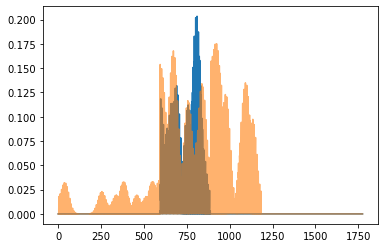

In [90]:
# examples of concatenated psts for all stimuli from 2 different neurons
plt.plot(tensorX[0].ravel('C'))
plt.plot(tensorX[51].ravel('C'),alpha=.6)

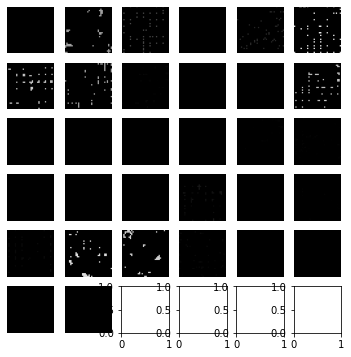

In [141]:
# Show (in space) which units were sampled from which feature maps in that layer

fmap_side = 36
fmap_used = np.unique(neurons_used[:,0])
nfmaps = fmap_used.size

#for each factor
for l in [1]:#sorted_factors:
    #create square grid
    grid_side = int(np.ceil(np.sqrt(nfmaps)))
    f,axes = plt.subplots(grid_side,grid_side,figsize=(grid_side,grid_side))

    canvas = np.zeros((nfmaps,fmap_side,fmap_side))
    for fi in range(nfmaps):
        #create sq array with neuronal activities in that factor
        #canvas = np.zeros((fmap_side,fmap_side))
        fmap_nis = np.flatnonzero([neurons_used[:,0] == fmap_used[fi]])
        canvas[([fi]*len(fmap_nis),neurons_used[fmap_nis,1],neurons_used[fmap_nis,2])] = neural_factors[fmap_nis,l]
    vmin = 0
    vmax = canvas.max()
    for fi in range(nfmaps):
        axes[fi//grid_side,fi%grid_side].imshow(canvas[fi], vmin=vmin, vmax=vmax, cmap='binary_r')
        axes[fi//grid_side,fi%grid_side].axis('off')
    plt.show()            
    break

### compute CP decomposition

In [93]:
CPMETHOD = 'shift'
AREA = 'deepnet'
tensorname = '%s-%s-%s-%s' % (PREFIX,PREFIX2,AREA,CPMETHOD)
print(tensorname)

nreps = 5
NDIRS = 8

minrank,maxrank,rankstep = 2,40,1 #inclusive

# save tensor as .mat file
from scipy.io import savemat
savemat(tfname,{'X':mytensor})

# run run_permcp.m

res50_shifted_i3_n1575_SCL0_5_TL37_activation_maxFmeanN_imMax-relNorm_sig3_SF-deepnet-shift


### load distance matrix and check for outliers

In [ ]:
# for CNNs, it's a good idea to remove any obvious outliers before running IAN
# load D2 as computed in `encoding-manifold.ipynb`
D2 = np.load(f'temp_D2_deepnets_{PREFIX}-{PREFIX2}.npy')

# this histogram of distance to nearest nbrs helps identifying them (if present)
# wanna remove points that have either this 1-NN distance too close to 0 (e.g. two neurons that had near zero response to everything)
# or neurons that were too different than everything else


D1 = np.sqrt(D2)
mindists = np.min(D1 + np.eye(N)*D1.max(),axis=0)
meanmind = mindists.mean()
medianmind = np.median(mindists)
#https://www.statisticshowto.com/choose-bin-sizes-statistics/
for n_bins in ['fd']:#,'doane','stone']:
    if type(n_bins) is str:
        try:
            bin_edges = np.histogram_bin_edges(mindists,n_bins)
        except:
            continue
        n_bins = len(bin_edges)-1
    # plt.plot(np.r_[edges[0],(edges[1:]+edges[:-1])/2],np.r_[0,counts])
    counts,edges,_ = plt.hist(mindists,n_bins,histtype='step',density=True,label=f'{n_bins} bins')
plt.plot([meanmind,meanmind],[0,counts.max()],'k--',label='mean')
plt.plot([medianmind,medianmind],[0,counts.max()],'r--',label='median')
plt.legend()
plt.show()

### load IAN weighted graph

In [56]:
wG = sp.sparse.load_npz(f'temp_wG_deepnets_{PREFIX}-{PREFIX2}.npz')

# also need to remove from wG any points that were disconnected (`disc_pts`) during the IAN optimization

# if that happened, keep a list of `nonoutliers` to filter the points actually used 
nonoutliers = range(wG.shape[0])


### compute diff map

In [57]:
Psi,lams = diffusionMapSparseK(wG, 20, 1, t=1)
Psi *= 10
c = neurons_used[nonoutliers,0] #color labels for the different feature maps

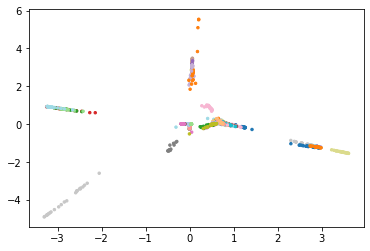

In [59]:
# flip thru diff coords to see the multiple clusters (usually strongly associated with a specific feature map)
plt.scatter(*Psi[:,[5,6]].T,s=6,c=c,cmap='tab20')

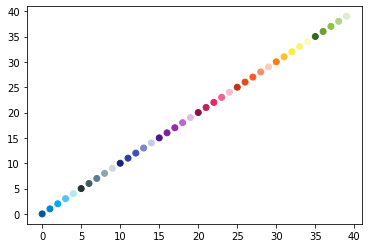

In [24]:
# nice colors to reasonably differentiate between up to 40 fmaps
palstr = np.array(['#03579b', '#0488d1', '#03a9f4', '#4fc3f7', '#b3e5fc', '#19237e',
          '#303f9f', '#3f51b5', '#7986cb', '#c5cae9', '#4a198c', '#7b21a2', '#9c27b0', '#ba68c8', '#e1bee7', '#88144f', '#c21f5b',
          '#e92663', '#f06292', '#f8bbd0', '#bf360c', '#e64a18', '#ff5722', '#ff8a65', '#ffccbc', '#f67f17', '#fbc02c', '#ffec3a',
          '#fff177', '#fdf9c3', '#33691d', '#689f38', '#8bc34a', '#aed581', '#ddedc8',
         '#253137', '#455a64', '#607d8b', '#90a4ae', '#cfd8dc',])

plt.scatter(range(len(palstr)),range(len(palstr)),c=palstr)

In [ ]:
# Nicer 3d scatter plot using plotly -- easier zooming, rotating, etc.

import plotly.graph_objects as go

# pick 3 coords to plot
dcs = [5,6,4];
import plotly.express as px


fig = go.Figure()
traces = []

#color palette
mypal = palstr


colors = neurons_used[nonoutliers,0]
fmapis = np.unique(colors)

hovertext = np.array(list(map(str,nonoutliers)))
hovertext = np.array(list(map(str,colors)))


for fi,fmapi in enumerate(fmapis):
    mask = colors==fmapi
    traces.append(go.Scatter3d(
        x=Psi[mask,dcs[0]],
        y=Psi[mask,dcs[1]],
        z=Psi[mask,dcs[2]],
        mode='markers',
        name='',
        hoverinfo='text',
        hovertext=hovertext[mask],
        marker=dict(
            size=4,
            color=mypal[fi],#'blue',
            opacity=1,
            #colorscale=colorscale,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)
radius = .5
dcranges = [(-radius,radius)]*3
dcranges = [None]*3
axis_visible = True
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,
                    paper_bgcolor="#f3f3f3",
                    scene={"aspectmode": "cube", 


                    "xaxis": dict(
                        title=f'dc{dcs[0]}',visible= axis_visible, showticklabels=False, range=dcranges[0]),
                    "yaxis": dict(
                        title=f'dc{dcs[1]}',visible= axis_visible, showticklabels=False, range=dcranges[1]),
                    "zaxis": dict(
                        title=f'dc{dcs[2]}',visible= axis_visible, showticklabels=False, range=dcranges[2])},)
fig.show()



